# 10. El problema de las $n$–reinas

Ana Gil Molina, Levi Malest Villarreal

### Enunciado

Tarea: Búsqueda

Dificultad: Media - alta

Coste computacional: Medio - alto

Implementar en Python un algoritmo evolutivo de representación con permutaciones para resolver el problema de las $n$–reinas. Comparar los dos siguientes esquemas, para $n = 64$:

- AE1: Selección proporcional, muestreo estocástico con reemplazo, sustitución generacional completa.

- AE2: Selección por ranking exponencial ($c = 0.3$), muestreo estocástico con reemplazo, sustitución generacional completa.

Añadir al criterio de terminación haber alcanzado la solución (para no hacer iteraciones innecesarias).

### Descripción del problema de las $n$-reinas

El problema de las $n$-reinas consiste en colocar $n$ reinas en un tablero de ajedrez de $n\times n$ de forma que ninguna reina ataque a otra. En el juego del ajedrez, la reina amenaza a aquellas piezas que se encuentren en su misma fila, columna o diagonal. Por ello, en el problema de las $n$-reinas, dos reinas no pueden compartir la misma fila, columna ni diagonal.

Representaremos cada individuo de la población mediante una permutación $x_i^t = (x_{i1}^t, x_{i2}^t, \dots, x_{in}^t)$, donde:

 - Cada índice representa una fila.
 - El valor en cada posición representa la columna en la que se encuentra la reina en esa fila.

Por ejemplo, para $n=4$, la permutación $(4,2,1,3)$ significa:

 - Reina en fila 1, columna 4
 - Reina en fila 2, columna 2
 - Reina en fila 3, columna 1
 - Reina en fila 4, columna 3

Esta representación asegura que no haya conflictos en las filas ni en las columnas. Faltaría evaluar posibles conflictos en las diagonales.

### Componentes
    
- <font size="3"> Representación con permutaciones
    
- <font size="3"> Selección proporcional (AE1) y selección por ranking exponencial (AE2)
    
- <font size="3"> Muestreo estocástico con reemplazamiento
    
- <font size="3"> Sustitución generacional completa
    
- <font size="3"> Elitista

- <font size="3"> Cruce PMX

- <font size="3"> Mutación por intercambio recíproco
    
---

### Requerimientos

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy.stats import wilcoxon 
from scipy.stats import mannwhitneyu
from statistics import mean

### Parámetros del algoritmo evolutivo
- $G$: Número de generaciones
- $N$: Tamaño de la población
- $random\_state$: Semilla para reproducibilidad
- $prob$: Probabilidades
  - $p\_c$: Probabilidad de cruce
  - $p\_m$: Probabilidad de mutación

### Definición del problema de optimización

$f$: Función objetivo

Gracias a la representación de la solución mediante permutaciones, se eliminan automáticamente los conflictos en las filas y las columnas. Sin embargo, las diagonales todavía pueden tener conflictos. Dos reinas están en la misma diagonal si:

 1. $fila_1 - columna_1 = fila_2 - columna_2$ (diagonal $\searrow$)
 2. $fila_1 + columna_1 = fila_2 + columna_2$ (diagonal $\nearrow$)

Esto es equivalente a la condición: $|fila_1 - fila_2| = |columna_1 - columna_2|$

La función de fitness contará los conflictos diagonales. Por tanto, el objetivo del problema será minimizar dicha función. Una solución válida se obtendrá cuando el fitness sea $0$.

In [2]:
def f(x):
    n = len(x)
    conflictos = 0
    for i in range(n):
        for j in range(i + 1, n):
            if abs(i - j) == abs(x[i] - x[j]):  # Conflicto diagonal
                conflictos += 1
    return conflictos

### Definición de individuo

Se define una clase `Individuo` para inicializar los individuos y su fitness correspondiente.

In [3]:
class Individuo:
    def __init__(self,n):
        self.x = np.zeros(n)
        self.f = 0.0
    def __lt__(self, ind):
        return self.f < ind.f

### Inicialización de la población

Mediante la función `InitializePopulation` se inicializa una población formada por permutaciones de longitud $n$.

In [4]:
def InitializePopulation(P):
    n = len(P[0].x)
    for I in P:
        I.x[:] = np.random.permutation(range(1,n+1))

### Función de evaluación

La función `evaluate` se usa para evaluar el fitness para un cierto individuo.

In [5]:
def evaluate(I,f):           
    I.f = f(I.x)

### Copia de individuo

In [6]:
def copia(I1, I2):
    np.copyto(I1.x, I2.x)
    I1.f = I2.f   

### Cálculo de las probabilidades acumuladas

La función `calculate_cumulative_probabilities` asigna a cada individuo de la población una probabilidad acumulada a partir de la probabilidad de ser seleccionado. Mediante el parámetro `selection_type` se puede escoger el esquema de selección entre selección proporcional (AE1) y selección por ranking exponencial (AE2).

 - La selección proporcional asigna a cada individuo la siguiente probabilidad:

    $$p_i^t = \frac{f(x_i^t)}{\sum_{i=1}^N f(x_i^t)}, i=1,\dots,N$$

    Este esquema de selección está diseñado para problemas de maximización con $f({\bf x})\geq 0$. En problemas de minimización se requiere transformar el fitness. En este algoritmo se ha hecho una transformación lineal de la siguiente forma:
 
    $$f'({\bf x})= C- f({\bf x}) $$

    donde $C$ es un valor  es un valor ligeramente superior al máximo valor de $f({\bf x})$ en la población actual:

    $$ C=\max_{{\bf x}\in P}\{f({\bf x})\}+\epsilon$$

    con $\epsilon=10^{-6}$.

 - La selección por ranking exponencial asigna a cada individuo la probabilidad:

    $$p_i^t = \frac{c-1}{c^N-1}c^{rank(c_i^t)-1}, i=1,\dots,N$$

    donde $c=0.3$ ($c$ cercano a $0$ significa mayor número esperado de descendientes del mejor individuo).

A partir de estas probabilidades, se calcula la probabilidad acumulada de cada cromosoma como:

$$q_i^t = \sum_{j=1}^i p_j^t, i=1,\dots, N $$

In [7]:
def calculate_cumulative_probabilities(cumulative_probabilities, P, N, C, selection_type):
    if selection_type == 'proportional':
        sum_fitness = sum(C - I.f for I in P)  # se usa C-f ya que el problema es de minimización
        cumulative_probabilities[0] = (C - P[0].f) / sum_fitness
        for i in range(1, N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1] + (C - P[i].f) / sum_fitness

    elif selection_type == 'exponential':
        c = 0.3  # Parámetro c para el ranking exponencial
        den = c**N - 1
        cumulative_probabilities[0] = (c - 1) / den
        for i in range(1, N):
            cumulative_probabilities[i] = cumulative_probabilities[i-1] + (c - 1) * c**i / den

### Selección (proporcional o por ranking exponencial) y muestreo estocástico con reemplazamiento (rueda de ruleta)

La función `selection` se utiliza para implementar un muestreo estocástico con reemplazamiento a partir de las probabilidades acumuladas calculadas con la función `calculate_cumulative_probabilities`. Este esquema de muestreo consiste en:

Repetir $N$ veces los siguientes pasos:

 - Extraer, con reemplazamiento, un número real aleatorio $r\sim \mathcal{U}(0,1)$.
 - Si $r\leq q_1^t$ entonces se muestrea el primer cromosoma de la población (i=1) en la generación $t$, y en otro caso se muestrea el $i$-ésimo cromosoma ($2\leq i\leq N$) tal que $q_{i-1}^t<r\leq q_i^t$.

In [8]:
def selection(P,cumulative_probabilities):
    r = np.random.random()
    i = 0
    while (cumulative_probabilities[i]<r):
        i += 1 
    return P[i]

### Cruce PMX

- Se realiza el cruce PMX con probabilidad $p\_c$.

El cruce PMX consiste en, dados dos padres $x_i^t$ y $x_j^t$, y dos puntos de cruce, por ejemplo:

$$x_i^t = (1, 2, 3 | 4, 5, 6, 7 | 8, 9)$$
$$x_j^t = (4, 5, 2 | 1, 8, 7, 6 | 9, 3)$$

se producen dos hijos $x_i'^t$ y $x_j'^t$, en principio ilegales, de la forma:

$$x_i'^t = (1, 2, 3 | 1, 8, 7, 6 | 8, 9)$$
$$x_j'^t = (4, 5, 2 | 4, 5, 6, 7 | 9, 3)$$

Después, para reparar los hijos de forma que sean una permutación, se establecen los siguientes mapeos entre los elementos dentro de ambos segmentos de cruce:

$1 \leftrightarrow 4$, $8 \leftrightarrow 5$, $7 \leftrightarrow 6$, $6 \leftrightarrow 7$

Se utilizan estos mapeos fuera de los segmentos de cruce, de forma que no se repita ningún elemento y se obtenga una permutación. Los hijos resultantes son:

$$x_i'^t = (4, 2, 3 | 1, 8, 7, 6 | 5, 9)$$
$$x_j'^t = (1, 8, 2 | 4, 5, 6, 7 | 9, 3)$$

La función `PMX_crossover` implementa este procedimiento, que se aplicará sobre dos padres con probabilidad $p\_c$.

In [9]:
def PMX_crossover(x1, x2, p_c):
    if np.random.random() <= p_c:
        n = len(x1)
        # 1. Seleccionar dos puntos de cruce distintos
        point1, point2 = np.sort(np.random.choice(n, 2, replace=False))

        # 2. Hacer una copia de los padres
        child1 = x1.copy()
        child2 = x2.copy()

        # 3. Copiar segmento de cruce
        child1[point1:point2] = x2[point1:point2]
        child2[point1:point2] = x1[point1:point2]

        # 4. Construir los mapeos para reparar duplicados
        mapping1 = {x2[i]: x1[i] for i in range(point1, point2)}    # Mapeo de x2 -> x1
        mapping2 = {x1[i]: x2[i] for i in range(point1, point2)}    # Mapeo de x1 -> x2

        # 5. Función para mapear valores y así reparar duplicados  
        def corregir_hijo(child, mapping, point1, point2):
            for i in range(n):
                # Se corrige fuera del segmento de cruce
                if i < point1 or i >= point2:
                    while child[i] in mapping:
                        # Reemplazar duplicados según el mapeo
                        child[i] = mapping[child[i]]
            return child
        
        # 6. Aplicar la reparación de duplicados
        child1 = corregir_hijo(child1, mapping1, point1, point2)
        child2 = corregir_hijo(child2, mapping2, point1, point2)
        
        # 7. Actualizar los individuos
        x1[:], x2[:] = child1, child2

### Mutación por intercambio recíproco

- Se realiza la mutación por intercambio recíproco con probabilidad $p\_m$.

La mutación por intercambio recíproco consiste en que un individuo $x_i^t$ muta en un nuevo individuo $x_i'^t$ mediante la selección aleatoria e intercambio de dos genes del cromosoma, asegurando una solución legal, por ejemplo:

$$x_i^t = (4, \mathbf{2}, 3 | 1, 8, 7, 6 | 5, \mathbf{9})$$

$$\downarrow$$

$$x_i'^t = (4, \mathbf{9}, 3 | 1, 8, 7, 6 | 5, \mathbf{2})$$

La función `reciprocal_exchange_mutation` esta mutación sobre un individuo con probabilidad $p\_m$.

In [10]:
def reciprocal_exchange_mutation(x,p_m):
    n = len(x)
    if np.random.random()<=p_m:
        pos1, pos2 = np.random.choice(n, 2, replace=False)
        x[pos1], x[pos2] = x[pos2], x[pos1]

### Progreso del algoritmo

In [11]:
def IniciaProgreso(P,G):
    best_outputs = [0]*(G+1) # Para visualizar la gráfica de evolución al final    
    progression_bar = tqdm()
    ActualizaProgreso(P,0,best_outputs,progression_bar)    
    return best_outputs,progression_bar
    
def ActualizaProgreso(P,gen,best_outputs,progression_bar):
    best_fitness = min(P).f
    progression_bar.set_description("Generation: %d Fitness: %f " % (gen, best_fitness))
    best_outputs[gen] = best_fitness # Añadir mejor fitness (para visualización)
    progression_bar.update(1)

### Algoritmo evolutivo

Mediante la función `EA` se implementa el algoritmo evolutivo. Con el parámetro `selection_type` se puede escoger el esquema de selección deseado, entre selección proporcional (AE1) y selección por ranking exponencial (AE2).

In [12]:
def EA(G, N, p_c, p_m, f, n, random_state, selection_type):
    '''
    Algoritmo evolutivo para el problema de las n-reinas con esquema de selección a elegir, muestreo
    estocástico con reemplazo, sustitución generacional completa, cruce PMX y mutación por intercambio recíproco.
    
    Parámetros:
     - G: número de generaciones
     - N: tamaño de la población
     - p_c: probabilidad de cruce
     - p_m: probabilidad de mutación
     - f: función de fitness a minimizar
     - n: dimensión del problema de las n-reinas
     - random_state: semilla para reproducibilidad
     - selection_type: tipo de selección que usa el algoritmo ('proportional' o 'exponential')
    '''
    
    # Fijar semilla para reproducibilidad
    np.random.seed(random_state)
    
    # Aserciones
    assert G >= 1, "El número de generaciones debe ser mayor o igual que 1."  
    assert N >= 2 and not N % 2, "El tamaño de la población debe ser par y mayor que 1."  
    
    def AssertProbability(p):
        assert p>=0 and p<=1, "La probabilidad debe estar entre 0 y 1."
    
    AssertProbability(p_c)
    AssertProbability(p_m)
    
    # Inicializar un array para almacenar las probabilidades acumuladas
    cumulative_probabilities = np.zeros(N)
    
    # Crear población inicial con N individuos
    P = [Individuo(n) for _ in range(N)]
    InitializePopulation(P)
    
    # Evaluar población inicial
    for I in P:      
        evaluate(I,f)
    
    # Crear población auxilar 
    Q = [Individuo(n) for _ in range(N)]
    
    # Para Elitismo    
    best_individuo = min(P)
    
    # Para transformación lineal
    eps = 10E-6
    C = max(P).f + eps    
   
    # Evoluciona durante G generaciones
    best_outputs, progression_bar = IniciaProgreso(P,G)    
    for g in range(1,G+1):

        # Verificar si se alcanzó la solución (función de fitness = 0)
        if min(P).f == 0:
            break  # Terminar la ejecución si la solución ha sido encontrada

        # Calcular las probabilidades acumuladas
        calculate_cumulative_probabilities(cumulative_probabilities, P, N, C, selection_type)

        # Iterar sobre la población en pares
        i = 0
        while i < N:
            
            # Seleccionar dos padres y copiarlos en Q
            copia(Q[i],selection(P,cumulative_probabilities))
            copia(Q[i+1],selection(P,cumulative_probabilities))

            # Aplicar cruce PMX con probabilidad p_c
            PMX_crossover(Q[i].x,Q[i+1].x,p_c)

            # Aplicar mutación por intercambio recíproco con probabilidad p_m
            reciprocal_exchange_mutation(Q[i].x,p_m)
            reciprocal_exchange_mutation(Q[i+1].x,p_m)
            
            # Siguiente par de individuos
            i += 2 
        
        # Se mantiene el mejor individuo (elitismo)
        copia(P[0], best_individuo)

        # Copiar los individuos de Q a P y evaluarlos
        for i in range(1,N):            
            copia(P[i],Q[i])
            evaluate(P[i],f)

        # Actualizar progreso
        ActualizaProgreso(P,g,best_outputs,progression_bar)
        best_individuo = min(P)
        C = max(P).f + eps
        
    return best_outputs, best_individuo.f, best_individuo.x

### Definición del Grid Search
- Se van a ajustar los siguientes parámetros del EA:
  - $p\_c$ (Probabilidad de cruce)
  - $p\_m$ (Probabilidad de mutación)

In [13]:
def GridSearchEA(options, n_repeat, G, N, selection_type): 
    '''
    Busqueda de la mejor combinación de parámetros p_c y p_m mediante Grid Search.

    Parámetros:
     - options: diccionario con listas de valores para p_c y p_m
     - n_repeat: número de veces que se ejecuta EA para cada combinación de parámetros
     - G: número de generaciones en el algoritmo evolutivo
     - N: tamaño de la población
     - selection_type: método de selección utilizado en EA
    '''
    best_score = float('inf')
    best_options = None

    # Recorrer todas las combinaciones posibles de p_c y p_m en options
    for p_c in options['p_c']:
        for p_m in options['p_m']:
            score = np.zeros(n_repeat)
            print("p_c:",p_c," p_m:",p_m)

            # Ejecutar el algoritmo evolutivo n_repeat veces 
            for i in range(n_repeat):
                _, score[i], _ = EA(G, N, p_c, p_m, f, n=64, random_state=i, selection_type=selection_type)

            # Promedio del score
            scoreMean = score.mean()
            print("Score Mean: ",scoreMean)
            print("")

            # Actualizar la mejor combinación de parámetros
            if scoreMean < best_score:
                best_score = scoreMean
                best_options = {'p_c': p_c, 'p_m': p_m}
    return best_score, best_options

## AE1: Selección proporcional, muestreo estocástico con reemplazo, sustitución generacional completa.

### Ejecución del Grid Search

In [14]:
options = {'p_c': np.linspace(0.01, 1, 10),
           'p_m': np.linspace(0.01, 0.3, 10)}

n_repeat = 3
G = 100
N = 30
best_score, best_options_AE1 = GridSearchEA(options=options,n_repeat=n_repeat,G=G,N=N, selection_type='proportional')

print("BEST:")
print('f: ', best_score)
print(best_options_AE1)

p_c: 0.01  p_m: 0.01


Generation: 100 Fitness: 20.000000 : : 101it [00:03, 30.90it/s]
Generation: 100 Fitness: 25.000000 : : 101it [00:03, 31.29it/s]
Generation: 100 Fitness: 24.000000 : : 101it [00:03, 32.90it/s]


Score Mean:  23.0

p_c: 0.01  p_m: 0.042222222222222223


Generation: 100 Fitness: 11.000000 : : 101it [00:03, 30.41it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:04, 24.82it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:03, 26.12it/s]


Score Mean:  13.333333333333334

p_c: 0.01  p_m: 0.07444444444444444


Generation: 100 Fitness: 12.000000 : : 101it [00:03, 32.10it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:04, 22.42it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 30.75it/s]


Score Mean:  12.666666666666666

p_c: 0.01  p_m: 0.10666666666666666


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 33.29it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 30.22it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 25.96it/s]


Score Mean:  11.666666666666666

p_c: 0.01  p_m: 0.1388888888888889


Generation: 100 Fitness: 13.000000 : : 101it [00:03, 28.48it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.82it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:03, 32.06it/s]


Score Mean:  12.333333333333334

p_c: 0.01  p_m: 0.1711111111111111


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.58it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 26.62it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.89it/s]


Score Mean:  8.0

p_c: 0.01  p_m: 0.20333333333333334


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.69it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.32it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.51it/s]


Score Mean:  8.333333333333334

p_c: 0.01  p_m: 0.23555555555555557


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.86it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.41it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 31.70it/s]


Score Mean:  8.666666666666666

p_c: 0.01  p_m: 0.2677777777777778


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.46it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.40it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 26.83it/s]


Score Mean:  8.666666666666666

p_c: 0.01  p_m: 0.3


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 29.75it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 28.12it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 30.83it/s]


Score Mean:  8.0

p_c: 0.12  p_m: 0.01


Generation: 100 Fitness: 21.000000 : : 101it [00:02, 35.21it/s]
Generation: 100 Fitness: 21.000000 : : 101it [00:03, 32.76it/s]
Generation: 100 Fitness: 23.000000 : : 101it [00:02, 35.82it/s]


Score Mean:  21.666666666666668

p_c: 0.12  p_m: 0.042222222222222223


Generation: 100 Fitness: 11.000000 : : 101it [00:03, 31.94it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.55it/s]
Generation: 100 Fitness: 16.000000 : : 101it [00:02, 33.73it/s]


Score Mean:  12.0

p_c: 0.12  p_m: 0.07444444444444444


Generation: 100 Fitness: 13.000000 : : 101it [00:02, 34.14it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 32.94it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 33.90it/s]


Score Mean:  11.666666666666666

p_c: 0.12  p_m: 0.10666666666666666


Generation: 100 Fitness: 12.000000 : : 101it [00:02, 36.40it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:02, 36.89it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 31.40it/s]


Score Mean:  12.333333333333334

p_c: 0.12  p_m: 0.1388888888888889


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 33.73it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.17it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 37.64it/s]


Score Mean:  9.0

p_c: 0.12  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 30.81it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 30.70it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.15it/s]


Score Mean:  7.666666666666667

p_c: 0.12  p_m: 0.20333333333333334


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.73it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:03, 28.40it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 32.14it/s]


Score Mean:  6.0

p_c: 0.12  p_m: 0.23555555555555557


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 30.45it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 29.78it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.01it/s]


Score Mean:  8.666666666666666

p_c: 0.12  p_m: 0.2677777777777778


Generation: 100 Fitness: 9.000000 : : 101it [00:03, 29.37it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 30.64it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.47it/s]


Score Mean:  9.0

p_c: 0.12  p_m: 0.3


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 30.44it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 38.26it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 37.05it/s]


Score Mean:  7.333333333333333

p_c: 0.23  p_m: 0.01


Generation: 100 Fitness: 19.000000 : : 101it [00:02, 39.14it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 31.05it/s]
Generation: 100 Fitness: 18.000000 : : 101it [00:02, 35.48it/s]


Score Mean:  16.666666666666668

p_c: 0.23  p_m: 0.042222222222222223


Generation: 100 Fitness: 12.000000 : : 101it [00:03, 33.24it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:04, 24.05it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 27.42it/s]


Score Mean:  14.333333333333334

p_c: 0.23  p_m: 0.07444444444444444


Generation: 100 Fitness: 9.000000 : : 101it [00:03, 29.82it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.74it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 31.00it/s]


Score Mean:  9.333333333333334

p_c: 0.23  p_m: 0.10666666666666666


Generation: 100 Fitness: 9.000000 : : 101it [00:03, 33.28it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 33.93it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.59it/s]


Score Mean:  9.0

p_c: 0.23  p_m: 0.1388888888888889


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.53it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 37.27it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 35.65it/s]


Score Mean:  8.0

p_c: 0.23  p_m: 0.1711111111111111


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 38.05it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 38.21it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.95it/s]


Score Mean:  8.333333333333334

p_c: 0.23  p_m: 0.20333333333333334


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 37.91it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 36.51it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 36.26it/s]


Score Mean:  9.0

p_c: 0.23  p_m: 0.23555555555555557


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.54it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 32.04it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 27.48it/s]


Score Mean:  6.0

p_c: 0.23  p_m: 0.2677777777777778


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 30.01it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.41it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:06, 16.01it/s]


Score Mean:  6.333333333333333

p_c: 0.23  p_m: 0.3


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 27.16it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 30.59it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:04, 21.74it/s]


Score Mean:  8.0

p_c: 0.34  p_m: 0.01


Generation: 100 Fitness: 18.000000 : : 101it [00:03, 28.45it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:03, 30.58it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 33.85it/s]


Score Mean:  15.0

p_c: 0.34  p_m: 0.042222222222222223


Generation: 100 Fitness: 12.000000 : : 101it [00:02, 38.41it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 37.19it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 38.84it/s]


Score Mean:  11.333333333333334

p_c: 0.34  p_m: 0.07444444444444444


Generation: 100 Fitness: 13.000000 : : 101it [00:02, 37.86it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 39.40it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 27.77it/s]


Score Mean:  10.666666666666666

p_c: 0.34  p_m: 0.10666666666666666


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 28.40it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 33.25it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:04, 22.31it/s]


Score Mean:  9.666666666666666

p_c: 0.34  p_m: 0.1388888888888889


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 37.97it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 31.17it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.68it/s]


Score Mean:  9.666666666666666

p_c: 0.34  p_m: 0.1711111111111111


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 32.14it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 32.40it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 30.45it/s]


Score Mean:  8.333333333333334

p_c: 0.34  p_m: 0.20333333333333334


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 37.59it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.26it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.24it/s]


Score Mean:  7.333333333333333

p_c: 0.34  p_m: 0.23555555555555557


Generation: 100 Fitness: 4.000000 : : 101it [00:02, 35.99it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.53it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.51it/s]


Score Mean:  6.666666666666667

p_c: 0.34  p_m: 0.2677777777777778


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.98it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.67it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.56it/s]


Score Mean:  8.0

p_c: 0.34  p_m: 0.3


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.29it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 37.60it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.92it/s]


Score Mean:  7.0

p_c: 0.45  p_m: 0.01


Generation: 100 Fitness: 15.000000 : : 101it [00:02, 37.12it/s]
Generation: 100 Fitness: 20.000000 : : 101it [00:04, 23.95it/s]
Generation: 100 Fitness: 16.000000 : : 101it [00:03, 32.90it/s]


Score Mean:  17.0

p_c: 0.45  p_m: 0.042222222222222223


Generation: 100 Fitness: 11.000000 : : 101it [00:03, 33.52it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:02, 34.21it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 29.00it/s]


Score Mean:  13.0

p_c: 0.45  p_m: 0.07444444444444444


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 37.70it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 33.40it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.32it/s]


Score Mean:  9.666666666666666

p_c: 0.45  p_m: 0.10666666666666666


Generation: 100 Fitness: 12.000000 : : 101it [00:03, 31.44it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.86it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 32.83it/s]


Score Mean:  10.666666666666666

p_c: 0.45  p_m: 0.1388888888888889


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 35.00it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.93it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.07it/s]


Score Mean:  6.333333333333333

p_c: 0.45  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 30.45it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.62it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 34.24it/s]


Score Mean:  8.666666666666666

p_c: 0.45  p_m: 0.20333333333333334


Generation: 100 Fitness: 3.000000 : : 101it [00:03, 32.12it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:03, 30.77it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:04, 24.40it/s]


Score Mean:  4.333333333333333

p_c: 0.45  p_m: 0.23555555555555557


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.62it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.43it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.20it/s]


Score Mean:  7.0

p_c: 0.45  p_m: 0.2677777777777778


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 26.99it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:04, 21.16it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:06, 15.53it/s]


Score Mean:  7.0

p_c: 0.45  p_m: 0.3


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 27.37it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 26.83it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 33.03it/s]


Score Mean:  6.0

p_c: 0.56  p_m: 0.01


Generation: 100 Fitness: 17.000000 : : 101it [00:03, 30.60it/s]
Generation: 100 Fitness: 18.000000 : : 101it [00:03, 31.12it/s]
Generation: 100 Fitness: 19.000000 : : 101it [00:02, 35.64it/s]


Score Mean:  18.0

p_c: 0.56  p_m: 0.042222222222222223


Generation: 100 Fitness: 11.000000 : : 101it [00:02, 34.46it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 30.00it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 33.51it/s]


Score Mean:  11.0

p_c: 0.56  p_m: 0.07444444444444444


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.67it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:04, 23.85it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 30.01it/s]


Score Mean:  9.0

p_c: 0.56  p_m: 0.10666666666666666


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.22it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 33.48it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 28.49it/s]


Score Mean:  8.666666666666666

p_c: 0.56  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:04, 24.09it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:05, 17.32it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:08, 12.25it/s]


Score Mean:  6.333333333333333

p_c: 0.56  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:04, 22.75it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:04, 22.90it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:04, 21.14it/s]


Score Mean:  6.666666666666667

p_c: 0.56  p_m: 0.20333333333333334


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 29.52it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.21it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 30.32it/s]


Score Mean:  7.0

p_c: 0.56  p_m: 0.23555555555555557


Generation: 100 Fitness: 4.000000 : : 101it [00:03, 27.06it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 32.20it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 30.39it/s]


Score Mean:  7.0

p_c: 0.56  p_m: 0.2677777777777778


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 34.66it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:04, 22.44it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 30.72it/s]


Score Mean:  7.333333333333333

p_c: 0.56  p_m: 0.3


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.52it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 33.14it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.45it/s]


Score Mean:  5.666666666666667

p_c: 0.67  p_m: 0.01


Generation: 100 Fitness: 17.000000 : : 101it [00:04, 21.17it/s]
Generation: 100 Fitness: 18.000000 : : 101it [00:03, 30.42it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:03, 29.76it/s]


Score Mean:  15.666666666666666

p_c: 0.67  p_m: 0.042222222222222223


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 30.77it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.77it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 27.55it/s]


Score Mean:  9.666666666666666

p_c: 0.67  p_m: 0.07444444444444444


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 30.15it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:02, 35.03it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 29.06it/s]


Score Mean:  10.0

p_c: 0.67  p_m: 0.10666666666666666


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.19it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 28.74it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 33.73it/s]


Score Mean:  9.0

p_c: 0.67  p_m: 0.1388888888888889


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.65it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 34.83it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 36.69it/s]


Score Mean:  8.0

p_c: 0.67  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.89it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.87it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 34.08it/s]


Score Mean:  6.333333333333333

p_c: 0.67  p_m: 0.20333333333333334


Generation: 100 Fitness: 4.000000 : : 101it [00:02, 34.04it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.27it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 33.48it/s]


Score Mean:  6.0

p_c: 0.67  p_m: 0.23555555555555557


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.23it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 33.48it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.43it/s]


Score Mean:  8.666666666666666

p_c: 0.67  p_m: 0.2677777777777778


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 33.19it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.26it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 33.24it/s]


Score Mean:  8.333333333333334

p_c: 0.67  p_m: 0.3


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.14it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 29.87it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 34.63it/s]


Score Mean:  5.333333333333333

p_c: 0.78  p_m: 0.01


Generation: 100 Fitness: 17.000000 : : 101it [00:02, 35.57it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:02, 36.39it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:02, 35.65it/s]


Score Mean:  16.0

p_c: 0.78  p_m: 0.042222222222222223


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.50it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.93it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:02, 35.49it/s]


Score Mean:  10.333333333333334

p_c: 0.78  p_m: 0.07444444444444444


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 36.10it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 31.64it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:04, 21.04it/s]


Score Mean:  10.0

p_c: 0.78  p_m: 0.10666666666666666


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 30.67it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.64it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 33.92it/s]


Score Mean:  7.333333333333333

p_c: 0.78  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 33.89it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.10it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.52it/s]


Score Mean:  7.666666666666667

p_c: 0.78  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.83it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.76it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.85it/s]


Score Mean:  7.666666666666667

p_c: 0.78  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 25.50it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.23it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 33.28it/s]


Score Mean:  7.333333333333333

p_c: 0.78  p_m: 0.23555555555555557


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 36.36it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 33.51it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 36.30it/s]


Score Mean:  5.0

p_c: 0.78  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 35.11it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.52it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.00it/s]


Score Mean:  7.333333333333333

p_c: 0.78  p_m: 0.3


Generation: 100 Fitness: 3.000000 : : 101it [00:02, 36.59it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.63it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 35.42it/s]


Score Mean:  5.666666666666667

p_c: 0.89  p_m: 0.01


Generation: 100 Fitness: 18.000000 : : 101it [00:03, 31.76it/s]
Generation: 100 Fitness: 16.000000 : : 101it [00:02, 34.53it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 33.07it/s]


Score Mean:  15.0

p_c: 0.89  p_m: 0.042222222222222223


Generation: 100 Fitness: 13.000000 : : 101it [00:02, 33.86it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 33.32it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 32.60it/s]


Score Mean:  12.333333333333334

p_c: 0.89  p_m: 0.07444444444444444


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.37it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.46it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:03, 26.81it/s]


Score Mean:  10.333333333333334

p_c: 0.89  p_m: 0.10666666666666666


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.88it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.73it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:04, 25.01it/s]


Score Mean:  6.0

p_c: 0.89  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 30.92it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.28it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 31.56it/s]


Score Mean:  7.0

p_c: 0.89  p_m: 0.1711111111111111


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 34.07it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.67it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.48it/s]


Score Mean:  7.0

p_c: 0.89  p_m: 0.20333333333333334


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.45it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.92it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 29.97it/s]


Score Mean:  6.333333333333333

p_c: 0.89  p_m: 0.23555555555555557


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.30it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 35.25it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.49it/s]


Score Mean:  7.0

p_c: 0.89  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.51it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 35.18it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.51it/s]


Score Mean:  6.333333333333333

p_c: 0.89  p_m: 0.3


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 31.56it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:04, 25.14it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:04, 24.35it/s]


Score Mean:  5.333333333333333

p_c: 1.0  p_m: 0.01


Generation: 100 Fitness: 11.000000 : : 101it [00:05, 18.67it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:05, 19.22it/s]
Generation: 100 Fitness: 18.000000 : : 101it [00:04, 22.59it/s]


Score Mean:  13.666666666666666

p_c: 1.0  p_m: 0.042222222222222223


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 26.56it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 31.54it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 32.56it/s]


Score Mean:  11.0

p_c: 1.0  p_m: 0.07444444444444444


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 33.72it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 29.28it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.34it/s]


Score Mean:  8.333333333333334

p_c: 1.0  p_m: 0.10666666666666666


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 36.73it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.84it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 37.40it/s]


Score Mean:  9.333333333333334

p_c: 1.0  p_m: 0.1388888888888889


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 34.00it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 37.41it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 28.43it/s]


Score Mean:  7.666666666666667

p_c: 1.0  p_m: 0.1711111111111111


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.24it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 33.30it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:05, 19.63it/s]


Score Mean:  7.0

p_c: 1.0  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 25.80it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 29.09it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 26.43it/s]


Score Mean:  6.0

p_c: 1.0  p_m: 0.23555555555555557


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 38.43it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.74it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.80it/s]


Score Mean:  7.333333333333333

p_c: 1.0  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.96it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 38.24it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 37.26it/s]


Score Mean:  7.666666666666667

p_c: 1.0  p_m: 0.3


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 38.11it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 37.03it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 38.11it/s]

Score Mean:  7.333333333333333

BEST:
f:  4.333333333333333
{'p_c': 0.45, 'p_m': 0.20333333333333334}


El Grid Search con AE1 ha tardado 16 minutos y 15 segundos.

### Nuevas ejecuciones del AE1 con los parámetros ajustados

In [15]:
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar

n_repeat = 10
G = 100
N = 100
p_c = best_options_AE1['p_c']
p_m = best_options_AE1['p_m']
print("p_c:",p_c," p_m:",p_m)
best_outputs_AE1 = np.full(n_repeat,None,dtype=object)
best_fitness_AE1 = np.zeros(n_repeat)
best_individuos_AE1 = []
for i in range(n_repeat):
    best_outputs_AE1[i], best_fitness_AE1[i], best_individuo = EA(G, N, p_c, p_m, f, n=64, random_state=i, selection_type='proportional')
    best_individuos_AE1.append(best_individuo)
print("Media: ",np.mean(best_fitness_AE1))
print("Máximo: ",np.max(best_fitness_AE1))
print("Mínimo: ",np.min(best_fitness_AE1))
print("Desviación estándar: ",np.std(best_fitness_AE1))

p_c: 0.45  p_m: 0.20333333333333334


Generation: 100 Fitness: 5.000000 : : 101it [00:10,  9.23it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:10, 10.00it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:09, 10.42it/s]
Generation: 100 Fitness: 3.000000 : : 101it [00:08, 11.54it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:16,  6.00it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:10,  9.84it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:11,  8.67it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:13,  7.64it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:11,  9.05it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:11,  8.93it/s]

Media:  5.6
Máximo:  7.0
Mínimo:  3.0
Desviación estándar:  1.2806248474865698


Las 10 ejecuciones de AE1 con los parámetros ya ajustados han tardado 1 minuto y 55 segundos.

### Visualización de la evolución del algoritmo AE1

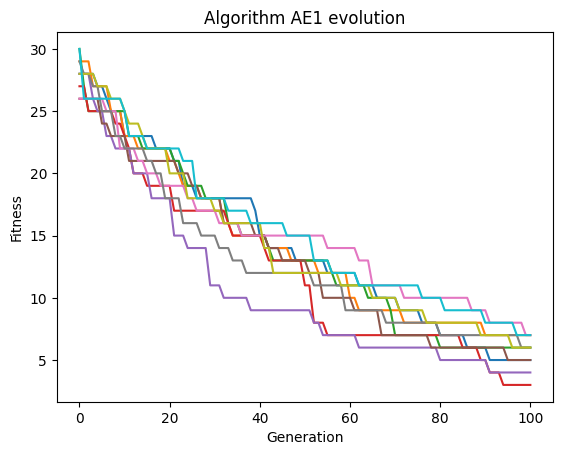

In [34]:
def VisualizaEvolucion(best_outputs, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    for best in best_outputs:
        plt.plot(best)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()
    
VisualizaEvolucion(best_outputs_AE1, "Algorithm AE1 evolution")

### Visualización de los tableros de las soluciones

In [17]:
def mostrar_tablero(permutacion):
    n = len(permutacion)  # Tamaño del tablero (n-reinas)
    tablero = [['.' for _ in range(n)] for _ in range(n)]  # Crear un tablero vacío
    
    for fila, columna in enumerate(permutacion):  # Colocamos las reinas
        tablero[fila][int(columna-1)] = 'R'
        
    # Imprimir el tablero
    for fila in tablero:
        print(" ".join(fila))
    print("\n")

# Mostrar los tableros de los mejores individuos de AE1
for i in range(n_repeat):
    print(f"Tablero AE1 - Run {i+1}:")
    mostrar_tablero(best_individuos_AE1[i])  # Mostrar tablero de AE1

Tablero AE1 - Run 1:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . .

## AE2: Selección por ranking exponencial ($c = 0.3$), muestreo estocástico con reemplazo, sustitución generacional completa.

### Ejecución del Grid Search

In [18]:
options = {'p_c': np.linspace(0.01, 1, 10),
           'p_m': np.linspace(0.01, 0.3, 10)}

n_repeat = 3
G = 100
N = 30
best_score, best_options_AE2 = GridSearchEA(options=options,n_repeat=n_repeat,G=G,N=N, selection_type='exponential')

print("BEST:")
print('f: ', best_score)
print(best_options_AE2)

p_c: 0.01  p_m: 0.01


Generation: 100 Fitness: 23.000000 : : 101it [00:03, 30.86it/s]
Generation: 100 Fitness: 25.000000 : : 101it [00:03, 32.63it/s]
Generation: 100 Fitness: 25.000000 : : 101it [00:03, 32.36it/s]


Score Mean:  24.333333333333332

p_c: 0.01  p_m: 0.042222222222222223


Generation: 100 Fitness: 11.000000 : : 101it [00:03, 28.60it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 26.90it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:04, 23.12it/s]


Score Mean:  14.0

p_c: 0.01  p_m: 0.07444444444444444


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 31.18it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.10it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.93it/s]


Score Mean:  9.666666666666666

p_c: 0.01  p_m: 0.10666666666666666


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 31.22it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.59it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:02, 34.43it/s]


Score Mean:  9.666666666666666

p_c: 0.01  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 33.93it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 30.27it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.91it/s]


Score Mean:  7.666666666666667

p_c: 0.01  p_m: 0.1711111111111111


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 33.14it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 30.31it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 33.30it/s]


Score Mean:  6.333333333333333

p_c: 0.01  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.68it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 33.48it/s]
Generation: 100 Fitness: 3.000000 : : 101it [00:02, 35.25it/s]


Score Mean:  5.666666666666667

p_c: 0.01  p_m: 0.23555555555555557


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 30.19it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 31.79it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.58it/s]


Score Mean:  7.0

p_c: 0.01  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 26.70it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.18it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.96it/s]


Score Mean:  6.333333333333333

p_c: 0.01  p_m: 0.3


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 33.57it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 37.65it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 33.92it/s]


Score Mean:  5.0

p_c: 0.12  p_m: 0.01


Generation: 100 Fitness: 22.000000 : : 101it [00:02, 34.85it/s]
Generation: 100 Fitness: 24.000000 : : 101it [00:02, 34.08it/s]
Generation: 100 Fitness: 22.000000 : : 101it [00:03, 33.30it/s]


Score Mean:  22.666666666666668

p_c: 0.12  p_m: 0.042222222222222223


Generation: 100 Fitness: 13.000000 : : 101it [00:03, 33.53it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 29.45it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:03, 30.51it/s]


Score Mean:  13.666666666666666

p_c: 0.12  p_m: 0.07444444444444444


Generation: 100 Fitness: 11.000000 : : 101it [00:04, 24.04it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 31.73it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 34.48it/s]


Score Mean:  10.666666666666666

p_c: 0.12  p_m: 0.10666666666666666


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.59it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 36.09it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:02, 37.44it/s]


Score Mean:  10.666666666666666

p_c: 0.12  p_m: 0.1388888888888889


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 33.93it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 28.82it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 34.79it/s]


Score Mean:  9.0

p_c: 0.12  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.10it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 33.48it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.79it/s]


Score Mean:  7.0

p_c: 0.12  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 27.16it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.37it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.33it/s]


Score Mean:  6.666666666666667

p_c: 0.12  p_m: 0.23555555555555557


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 34.03it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 37.12it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.79it/s]


Score Mean:  5.666666666666667

p_c: 0.12  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 33.73it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 33.71it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.69it/s]


Score Mean:  5.333333333333333

p_c: 0.12  p_m: 0.3


Generation: 100 Fitness: 4.000000 : : 101it [00:02, 34.47it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 33.94it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 33.33it/s]


Score Mean:  5.0

p_c: 0.23  p_m: 0.01


Generation: 100 Fitness: 23.000000 : : 101it [00:02, 34.43it/s]
Generation: 100 Fitness: 21.000000 : : 101it [00:02, 33.84it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:03, 32.07it/s]


Score Mean:  20.333333333333332

p_c: 0.23  p_m: 0.042222222222222223


Generation: 100 Fitness: 11.000000 : : 101it [00:04, 24.42it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 33.02it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:03, 31.38it/s]


Score Mean:  13.666666666666666

p_c: 0.23  p_m: 0.07444444444444444


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 33.99it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:02, 34.08it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 34.44it/s]


Score Mean:  11.666666666666666

p_c: 0.23  p_m: 0.10666666666666666


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.44it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 35.44it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.95it/s]


Score Mean:  9.0

p_c: 0.23  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 38.45it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 33.69it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.23it/s]


Score Mean:  8.0

p_c: 0.23  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 37.18it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 38.21it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 36.73it/s]


Score Mean:  8.0

p_c: 0.23  p_m: 0.20333333333333334


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 37.41it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.48it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 35.07it/s]


Score Mean:  5.666666666666667

p_c: 0.23  p_m: 0.23555555555555557


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.88it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.64it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:07, 13.13it/s]


Score Mean:  7.333333333333333

p_c: 0.23  p_m: 0.2677777777777778


Generation: 100 Fitness: 3.000000 : : 101it [00:04, 20.30it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:04, 25.01it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:04, 25.07it/s]


Score Mean:  5.0

p_c: 0.23  p_m: 0.3


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 29.89it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 29.44it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.12it/s]


Score Mean:  5.666666666666667

p_c: 0.34  p_m: 0.01


Generation: 100 Fitness: 19.000000 : : 101it [00:03, 32.25it/s]
Generation: 100 Fitness: 24.000000 : : 101it [00:04, 21.99it/s]
Generation: 100 Fitness: 18.000000 : : 101it [00:03, 32.39it/s]


Score Mean:  20.333333333333332

p_c: 0.34  p_m: 0.042222222222222223


Generation: 100 Fitness: 14.000000 : : 101it [00:03, 33.32it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:02, 36.86it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 35.71it/s]


Score Mean:  13.666666666666666

p_c: 0.34  p_m: 0.07444444444444444


Generation: 100 Fitness: 12.000000 : : 101it [00:02, 36.06it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:02, 35.40it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.92it/s]


Score Mean:  11.333333333333334

p_c: 0.34  p_m: 0.10666666666666666


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 28.64it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 35.63it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.24it/s]


Score Mean:  8.333333333333334

p_c: 0.34  p_m: 0.1388888888888889


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 33.28it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.07it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 37.18it/s]


Score Mean:  8.333333333333334

p_c: 0.34  p_m: 0.1711111111111111


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.43it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.61it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.70it/s]


Score Mean:  6.666666666666667

p_c: 0.34  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.79it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.22it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.24it/s]


Score Mean:  6.333333333333333

p_c: 0.34  p_m: 0.23555555555555557


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.99it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 35.22it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 36.95it/s]


Score Mean:  5.0

p_c: 0.34  p_m: 0.2677777777777778


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.68it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 32.41it/s]
Generation: 100 Fitness: 2.000000 : : 101it [00:02, 34.89it/s]


Score Mean:  4.333333333333333

p_c: 0.34  p_m: 0.3


Generation: 100 Fitness: 5.000000 : : 101it [00:02, 35.84it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 35.46it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.74it/s]


Score Mean:  5.0

p_c: 0.45  p_m: 0.01


Generation: 100 Fitness: 20.000000 : : 101it [00:03, 28.98it/s]
Generation: 100 Fitness: 25.000000 : : 101it [00:02, 36.73it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:07, 13.14it/s]


Score Mean:  20.666666666666668

p_c: 0.45  p_m: 0.042222222222222223


Generation: 100 Fitness: 13.000000 : : 101it [00:03, 28.44it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:02, 37.24it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 36.03it/s]


Score Mean:  12.333333333333334

p_c: 0.45  p_m: 0.07444444444444444


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 37.18it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.42it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 34.26it/s]


Score Mean:  9.333333333333334

p_c: 0.45  p_m: 0.10666666666666666


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 36.31it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 36.58it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 31.26it/s]


Score Mean:  9.0

p_c: 0.45  p_m: 0.1388888888888889


Generation: 100 Fitness: 9.000000 : : 101it [00:02, 36.15it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 32.57it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.26it/s]


Score Mean:  7.333333333333333

p_c: 0.45  p_m: 0.1711111111111111


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 32.57it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.64it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 32.22it/s]


Score Mean:  7.333333333333333

p_c: 0.45  p_m: 0.20333333333333334


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 27.74it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:04, 24.48it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:04, 24.99it/s]


Score Mean:  5.0

p_c: 0.45  p_m: 0.23555555555555557


Generation: 100 Fitness: 2.000000 : : 101it [00:03, 29.24it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 27.38it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.19it/s]


Score Mean:  6.0

p_c: 0.45  p_m: 0.2677777777777778


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 30.20it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 25.47it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 29.90it/s]


Score Mean:  5.333333333333333

p_c: 0.45  p_m: 0.3


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 30.03it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.89it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 35.55it/s]


Score Mean:  5.0

p_c: 0.56  p_m: 0.01


Generation: 100 Fitness: 22.000000 : : 101it [00:03, 32.04it/s]
Generation: 100 Fitness: 24.000000 : : 101it [00:02, 34.26it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:02, 34.05it/s]


Score Mean:  21.0

p_c: 0.56  p_m: 0.042222222222222223


Generation: 100 Fitness: 14.000000 : : 101it [00:02, 35.65it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 29.96it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 32.04it/s]


Score Mean:  13.666666666666666

p_c: 0.56  p_m: 0.07444444444444444


Generation: 100 Fitness: 13.000000 : : 101it [00:04, 24.59it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:03, 33.63it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 32.75it/s]


Score Mean:  11.666666666666666

p_c: 0.56  p_m: 0.10666666666666666


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 32.76it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 30.61it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 36.75it/s]


Score Mean:  10.333333333333334

p_c: 0.56  p_m: 0.1388888888888889


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.94it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 34.68it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.31it/s]


Score Mean:  9.0

p_c: 0.56  p_m: 0.1711111111111111


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 28.43it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 30.50it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.00it/s]


Score Mean:  6.666666666666667

p_c: 0.56  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.08it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.72it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 34.30it/s]


Score Mean:  7.333333333333333

p_c: 0.56  p_m: 0.23555555555555557


Generation: 100 Fitness: 3.000000 : : 101it [00:03, 32.60it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.03it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.10it/s]


Score Mean:  5.666666666666667

p_c: 0.56  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 35.72it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:03, 25.38it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.37it/s]


Score Mean:  5.333333333333333

p_c: 0.56  p_m: 0.3


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 27.66it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.00it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 34.15it/s]


Score Mean:  5.666666666666667

p_c: 0.67  p_m: 0.01


Generation: 100 Fitness: 22.000000 : : 101it [00:03, 31.21it/s]
Generation: 100 Fitness: 26.000000 : : 101it [00:02, 35.00it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:03, 33.21it/s]


Score Mean:  21.0

p_c: 0.67  p_m: 0.042222222222222223


Generation: 100 Fitness: 9.000000 : : 101it [00:03, 31.77it/s]
Generation: 100 Fitness: 14.000000 : : 101it [00:03, 29.95it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:03, 32.47it/s]


Score Mean:  12.0

p_c: 0.67  p_m: 0.07444444444444444


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 27.25it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:03, 31.14it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.91it/s]


Score Mean:  9.666666666666666

p_c: 0.67  p_m: 0.10666666666666666


Generation: 100 Fitness: 11.000000 : : 101it [00:03, 33.03it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:02, 34.45it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.70it/s]


Score Mean:  10.333333333333334

p_c: 0.67  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.02it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 27.66it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 29.69it/s]


Score Mean:  8.333333333333334

p_c: 0.67  p_m: 0.1711111111111111


Generation: 100 Fitness: 9.000000 : : 101it [00:03, 33.51it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 33.77it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.19it/s]


Score Mean:  8.0

p_c: 0.67  p_m: 0.20333333333333334


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.20it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.89it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 29.15it/s]


Score Mean:  6.333333333333333

p_c: 0.67  p_m: 0.23555555555555557


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 33.56it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 34.27it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 34.30it/s]


Score Mean:  7.333333333333333

p_c: 0.67  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 26.80it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.99it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.87it/s]


Score Mean:  7.0

p_c: 0.67  p_m: 0.3


Generation: 100 Fitness: 4.000000 : : 101it [00:03, 28.74it/s]
Generation: 100 Fitness: 3.000000 : : 101it [00:03, 31.73it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 32.51it/s]


Score Mean:  4.0

p_c: 0.78  p_m: 0.01


Generation: 100 Fitness: 23.000000 : : 101it [00:03, 31.79it/s]
Generation: 100 Fitness: 20.000000 : : 101it [00:02, 34.62it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:04, 24.47it/s]


Score Mean:  20.0

p_c: 0.78  p_m: 0.042222222222222223


Generation: 100 Fitness: 12.000000 : : 101it [00:03, 33.04it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:02, 33.97it/s]
Generation: 100 Fitness: 18.000000 : : 101it [00:02, 34.83it/s]


Score Mean:  15.0

p_c: 0.78  p_m: 0.07444444444444444


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 34.34it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.61it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 28.93it/s]


Score Mean:  9.666666666666666

p_c: 0.78  p_m: 0.10666666666666666


Generation: 100 Fitness: 10.000000 : : 101it [00:03, 27.29it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 38.35it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 33.57it/s]


Score Mean:  7.666666666666667

p_c: 0.78  p_m: 0.1388888888888889


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 30.29it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 32.43it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 33.26it/s]


Score Mean:  6.333333333333333

p_c: 0.78  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 33.12it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 30.63it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 35.44it/s]


Score Mean:  8.666666666666666

p_c: 0.78  p_m: 0.20333333333333334


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.77it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 32.23it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.24it/s]


Score Mean:  7.0

p_c: 0.78  p_m: 0.23555555555555557


Generation: 100 Fitness: 4.000000 : : 101it [00:04, 20.25it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 29.19it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:02, 35.90it/s]


Score Mean:  7.333333333333333

p_c: 0.78  p_m: 0.2677777777777778


Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.62it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.73it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.26it/s]


Score Mean:  7.0

p_c: 0.78  p_m: 0.3


Generation: 100 Fitness: 4.000000 : : 101it [00:03, 33.32it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:03, 32.41it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 35.90it/s]


Score Mean:  4.333333333333333

p_c: 0.89  p_m: 0.01


Generation: 100 Fitness: 23.000000 : : 101it [00:03, 27.81it/s]
Generation: 100 Fitness: 25.000000 : : 101it [00:02, 35.42it/s]
Generation: 100 Fitness: 20.000000 : : 101it [00:02, 35.68it/s]


Score Mean:  22.666666666666668

p_c: 0.89  p_m: 0.042222222222222223


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.69it/s]
Generation: 100 Fitness: 16.000000 : : 101it [00:03, 31.28it/s]
Generation: 100 Fitness: 17.000000 : : 101it [00:03, 32.23it/s]


Score Mean:  13.666666666666666

p_c: 0.89  p_m: 0.07444444444444444


Generation: 100 Fitness: 11.000000 : : 101it [00:02, 35.72it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:02, 36.27it/s]
Generation: 100 Fitness: 12.000000 : : 101it [00:02, 36.37it/s]


Score Mean:  10.333333333333334

p_c: 0.89  p_m: 0.10666666666666666


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 38.82it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 26.26it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 26.86it/s]


Score Mean:  8.0

p_c: 0.89  p_m: 0.1388888888888889


Generation: 100 Fitness: 6.000000 : : 101it [00:03, 32.78it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.56it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.22it/s]


Score Mean:  6.333333333333333

p_c: 0.89  p_m: 0.1711111111111111


Generation: 100 Fitness: 6.000000 : : 101it [00:02, 34.97it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 30.31it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 30.73it/s]


Score Mean:  8.0

p_c: 0.89  p_m: 0.20333333333333334


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 31.59it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.78it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 32.49it/s]


Score Mean:  6.666666666666667

p_c: 0.89  p_m: 0.23555555555555557


Generation: 100 Fitness: 7.000000 : : 101it [00:03, 28.03it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 35.44it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 34.83it/s]


Score Mean:  6.333333333333333

p_c: 0.89  p_m: 0.2677777777777778


Generation: 100 Fitness: 3.000000 : : 101it [00:02, 34.40it/s]
Generation: 100 Fitness: 3.000000 : : 101it [00:02, 36.69it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:02, 35.44it/s]


Score Mean:  4.0

p_c: 0.89  p_m: 0.3


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 27.47it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:02, 34.19it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:04, 23.60it/s]


Score Mean:  5.333333333333333

p_c: 1.0  p_m: 0.01


Generation: 100 Fitness: 24.000000 : : 101it [00:02, 34.23it/s]
Generation: 100 Fitness: 16.000000 : : 101it [00:03, 32.41it/s]
Generation: 100 Fitness: 21.000000 : : 101it [00:03, 31.92it/s]


Score Mean:  20.333333333333332

p_c: 1.0  p_m: 0.042222222222222223


Generation: 100 Fitness: 15.000000 : : 101it [00:03, 31.81it/s]
Generation: 100 Fitness: 15.000000 : : 101it [00:03, 33.64it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 33.13it/s]


Score Mean:  13.666666666666666

p_c: 1.0  p_m: 0.07444444444444444


Generation: 100 Fitness: 8.000000 : : 101it [00:02, 33.70it/s]
Generation: 100 Fitness: 13.000000 : : 101it [00:02, 34.87it/s]
Generation: 100 Fitness: 11.000000 : : 101it [00:03, 32.84it/s]


Score Mean:  10.666666666666666

p_c: 1.0  p_m: 0.10666666666666666


Generation: 100 Fitness: 10.000000 : : 101it [00:02, 33.73it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:03, 31.24it/s]
Generation: 100 Fitness: 10.000000 : : 101it [00:02, 33.68it/s]


Score Mean:  10.0

p_c: 1.0  p_m: 0.1388888888888889


Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.61it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 32.10it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:02, 33.67it/s]


Score Mean:  6.666666666666667

p_c: 1.0  p_m: 0.1711111111111111


Generation: 100 Fitness: 8.000000 : : 101it [00:03, 33.08it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.23it/s]
Generation: 100 Fitness: 9.000000 : : 101it [00:03, 32.59it/s]


Score Mean:  8.333333333333334

p_c: 1.0  p_m: 0.20333333333333334


Generation: 100 Fitness: 7.000000 : : 101it [00:04, 21.93it/s]
Generation: 100 Fitness: 8.000000 : : 101it [00:03, 32.24it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:03, 31.73it/s]


Score Mean:  7.333333333333333

p_c: 1.0  p_m: 0.23555555555555557


Generation: 100 Fitness: 5.000000 : : 101it [00:03, 33.48it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 27.23it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:03, 33.35it/s]


Score Mean:  5.333333333333333

p_c: 1.0  p_m: 0.2677777777777778


Generation: 100 Fitness: 4.000000 : : 101it [00:03, 33.57it/s]
Generation: 100 Fitness: 7.000000 : : 101it [00:02, 36.49it/s]
Generation: 100 Fitness: 5.000000 : : 101it [00:04, 25.04it/s]


Score Mean:  5.333333333333333

p_c: 1.0  p_m: 0.3


Generation: 100 Fitness: 3.000000 : : 101it [00:02, 34.50it/s]
Generation: 100 Fitness: 6.000000 : : 101it [00:03, 29.71it/s]
Generation: 100 Fitness: 4.000000 : : 101it [00:04, 25.19it/s]

Score Mean:  4.333333333333333

BEST:
f:  4.0
{'p_c': 0.67, 'p_m': 0.3}


El Grid Search con AE2 ha tardado 15 minutos y 59 segundos.

### Nuevas ejecuciones del AE2 con los parámetros ajustados

In [19]:
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar

n_repeat = 10
G = 100
N = 100
p_c = best_options_AE2['p_c']
p_m = best_options_AE2['p_m']
print("p_c:",p_c," p_m:",p_m)
best_outputs_AE2 = np.full(n_repeat,None,dtype=object)
best_fitness_AE2 = np.zeros(n_repeat)
best_individuos_AE2 = []
for i in range(n_repeat):
    best_outputs_AE2[i], best_fitness_AE2[i], best_individuo = EA(G, N, p_c, p_m, f, n=64, random_state=i, selection_type='exponential')
    best_individuos_AE2.append(best_individuo)
print("Media: ",np.mean(best_fitness_AE2))
print("Máximo: ",np.max(best_fitness_AE2))
print("Mínimo: ",np.min(best_fitness_AE2))
print("Desviación estándar: ",np.std(best_fitness_AE2))

p_c: 0.67  p_m: 0.3


Generation: 100 Fitness: 1.000000 : : 101it [00:12,  8.24it/s]
Generation: 100 Fitness: 2.000000 : : 101it [00:11,  8.68it/s]
Generation: 100 Fitness: 2.000000 : : 101it [00:13,  7.75it/s]
Generation: 100 Fitness: 1.000000 : : 101it [00:10,  9.38it/s]
Generation: 100 Fitness: 1.000000 : : 101it [00:11,  8.90it/s]
Generation: 100 Fitness: 2.000000 : : 101it [00:11,  8.97it/s]
Generation: 88 Fitness: 0.000000 : : 89it [00:09,  9.77it/s] 
Generation: 100 Fitness: 2.000000 : : 101it [00:11,  8.55it/s]
Generation: 100 Fitness: 1.000000 : : 101it [00:15,  6.64it/s]
Generation: 100 Fitness: 3.000000 : : 101it [00:19,  5.10it/s]

Media:  1.5
Máximo:  3.0
Mínimo:  0.0
Desviación estándar:  0.806225774829855


Las 10 ejecuciones de AE2 con los parámetros ya ajustados han tardado 2 minutos y 7 segundos.

### Visualización de la evolución del algoritmo AE2

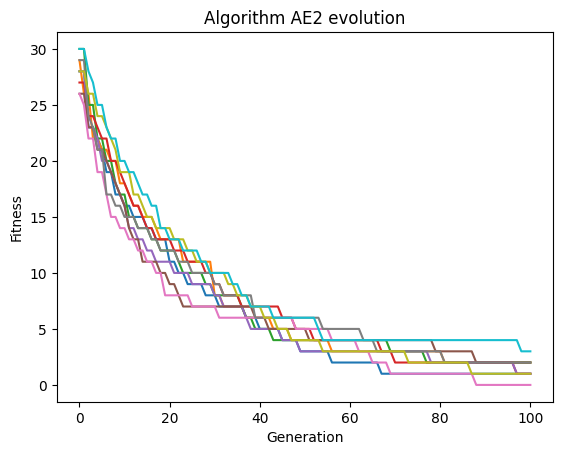

In [35]:
VisualizaEvolucion(best_outputs_AE2, "Algorithm AE2 evolution")

### Visualización de los tableros de las soluciones

In [21]:
# Mostrar los tableros de los mejores individuos de AE2
for i in range(n_repeat):
    print(f"Tablero AE2 - Run {i+1}:")
    mostrar_tablero(best_individuos_AE2[i])  # Mostrar tablero de AE2

Tablero AE2 - Run 1:
. . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . .
. . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R .

## Test estadísticos

### Descripción

<font size="4"> Comparación de los algoritmos usando test estadísticos.
    
### Componentes
    
- <font size="3"> Se requiere un fichero csv, donde las columnas representan los algoritmos a comparar y las filas son las muestras de los resultados.
    
- <font size="3"> Se calculan ranking wins - loss para los siguientes test estadísticos:

    - <font size="3"> Mann-Whitney U test (Wilconxon rank-sum test), apropiado para la comparación  de algoritmos probabilistas ejecutados múltiples veces con distintas semillas (muestras independientes).

    - Wilcoxon signed-rank test, apropiado para la comparación de algoritmos de aprendizaje evaluados en $k$-fold cross-validation, $n$ repeticiones (muestras pareadas).

- <font size="3"> Se calcula también el ranking wins - loss de los resultados medios. 
    
---

In [22]:
# Crear una matriz con los resultados
results = np.column_stack((best_fitness_AE1, best_fitness_AE2))

# Guardar en un archivo CSV los resultados
np.savetxt("n_reinas_results.csv", results, fmt="%.2f", delimiter=",", header="AE1,AE2", comments="")

### Definición del tipo de test (minimización)

In [23]:
def mejor(x,y):
    return x<y # minimización

def peor(x,y):
    return x>y # minimización

### Definición de la clase Ranking

In [24]:
class Ranking:
    def __init__(self, name):
        self.name = name # Nombre del algoritmo
        self.wins = 0 # Veces que ha ganado
        self.losses = 0 # Veces que ha perdido
    def __lt__(self,x):
        return (self.wins-self.losses) < (x.wins-x.losses)
    def __str__(self):
        return f"{self.name:<15} {self.wins:>10} {self.losses:>10} {self.wins - self.losses:>15}"

### Calcula la matriz de wins - losses de las medias a partir de los scores del problema

In [25]:
def CalculateWinsLossesMatrixMean(scores):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if mejor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = 1
                WinLossMatriz[j,i] = -1
            if peor(mean(score_i),mean(score_j)):
                WinLossMatriz[i,j] = -1
                WinLossMatriz[j,i] = 1
    return WinLossMatriz

### Calcula las veces que cada algoritmo ha ganado y ha perdido a partir de la matriz de wins - losses del problema

In [26]:
def CalculateWinsLossesAmount(WinsLossesMatriz,labels):
    nScores = len(labels)
    WinsLossesAmount = [Ranking(scoreName) for scoreName in labels]
    for i in range(nScores-1):            
        for j in range(i+1,nScores):
            if WinsLossesMatriz[i,j]==1:            
                WinsLossesAmount[i].wins += 1
                WinsLossesAmount[j].losses += 1
            if WinsLossesMatriz[i,j]==-1:            
                WinsLossesAmount[j].wins += 1
                WinsLossesAmount[i].losses += 1
    return WinsLossesAmount

### Acumula las cantidades de wins - losses del problema

In [27]:
def AddWinsLossesAmount(WinsLossesTotalAmount,WinsLossesAmount):
    for i in range(len(WinsLossesAmount)):
        WinsLossesTotalAmount[i].wins += WinsLossesAmount[i].wins
        WinsLossesTotalAmount[i].losses += WinsLossesAmount[i].losses

### Calcula la matriz de wins - losses de las diferencias estadísticamente significativas para un test estadistico dado, junto con la matriz de p-values, a partir de los scores del problema

In [28]:
def CalculateWinsLossesMatrixStat(scores,stat):
    labels = scores.columns.values
    nScores = len(labels)
    WinLossMatriz = np.zeros((nScores,nScores)) 
    pValues = np.zeros((nScores,nScores)) 
    for i in range(nScores-1):            
        score_i = scores.iloc[:,i].values
        for j in range(i+1,nScores):
            score_j = scores.iloc[:,j].values
            if not all(x_i == y_i for x_i, y_i in zip(score_i, score_j)): # si son datos diferentes
                _, p_value = stat(score_i, score_j)  
                pValues[i,j] = p_value
                pValues[j,i] = p_value                
                if p_value<0.05:
                    if mejor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = 1
                        WinLossMatriz[j,i] = -1                        
                    if peor(mean(score_i),mean(score_j)):
                        WinLossMatriz[i,j] = -1
                        WinLossMatriz[j,i] = 1                        
    return WinLossMatriz,pValues

### Impresión de la matriz wins - losses

In [29]:
def PrintMatriz(WinLossMatriz,labels):
    print("win: El algoritmo en la columna gana al algoritmo de la fila")
    print("loss: El algoritmo en la columna pierde frente al algoritmo de la fila")
    print("tie: El algoritmo en la columna empata con al algoritmo de la fila")
    n = len(labels)
    col_width = 10  # Ancho fijo para cada columna
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == 1:
                print(f"{'win':>{col_width}}", end="")
            elif WinLossMatriz[j,i] == -1:
                print(f"{'loss':>{col_width}}", end="")
            else:
                print(f"{'tie':>{col_width}}", end="")
        print()

### Impresión  del ranking wins - losses

In [30]:
def PrintRanking(WinLoss):
    Ranking = sorted(WinLoss, reverse=True)    
    print(f"{'Ranking':<15} {'Wins':>10} {'Losses':>10} {'Wins-Losses':>15}")
    for r in Ranking:
        print(r)

### Impresión de la matriz de p-values

In [31]:
def PrintPValuesMatriz(pValues, labels):
    n = len(labels)
    col_width = 15  # Ancho fijo para cada columna, ajusta según sea necesario
    print("p-values")
    # Imprimir encabezados de columna
    print(" " * col_width, end="")
    for j in range(n):
        print(f"{labels[j]:>{col_width}}", end="")
    print()

    # Imprimir filas con datos
    for i in range(n):
        print(f"{labels[i]:<{col_width}}", end="")
        for j in range(n):
            if i == j:
                print(f"{'-':>{col_width}}", end="")
            else:
                print(f"{pValues[i,j]:>{col_width}.8f}", end="")
        print()

### Realización de los test estadísticos e impresión de resultados

In [32]:
fileName = ["n_reinas_results"]

scores = pd.read_csv(fileName[0]+".csv") # Se coje el primero de ellos para crear los objetos de la clase Ranking
labels = scores.columns.values # Nombres de los algoritmos
WinsLossesTotalAmountMean = [Ranking(scoreName) for scoreName in labels]
WinsLossesTotalAmountRanksum = [Ranking(scoreName) for scoreName in labels]
WinsLossesTotalAmountSignedRank = [Ranking(scoreName) for scoreName in labels]

for file in fileName:

    scores = pd.read_csv(file+".csv")
    print("file = ",file)
    print(scores)
    print('\n')
    
    # WINS-LOSSES DE MEDIAS
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    WinsLossesMatrizMean = CalculateWinsLossesMatrixMean(scores) 
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountMean = CalculateWinsLossesAmount(WinsLossesMatrizMean,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountMean,WinsLossesAmountMean)
    print("Mean")
    PrintMatriz(WinsLossesMatrizMean,labels)
    PrintRanking(WinsLossesAmountMean)
    print('\n')
  
    # WINS-LOSSES Y P-VALUES DE RANK-SUM
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    # y matriz de dos dimensiones para los p-values
    WinsLossesMatrizRanksum, pValuesRanksum = CalculateWinsLossesMatrixStat(scores,mannwhitneyu)
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountRanksum = CalculateWinsLossesAmount(WinsLossesMatrizRanksum,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountRanksum,WinsLossesAmountRanksum)
    print("Ranksum")    
    PrintMatriz(WinsLossesMatrizRanksum,labels)
    PrintPValuesMatriz(pValuesRanksum, labels)    
    PrintRanking(WinsLossesAmountRanksum)
    print('\n')
    
    # WINS-LOSSES Y P-VALUES DE SIGNED-RANK
    # Matriz de dos dimensiones con valores -1, 0, 1 para comparar los algoritmos en cada problema
    # y matriz de dos dimensiones para los p-values
    WinsLossesMatrizSignedRank, pValuesSignedRank = CalculateWinsLossesMatrixStat(scores,wilcoxon)
    # Lista con los objetos Ranking de cada algoritmo 
    WinsLossesAmountSignedRank = CalculateWinsLossesAmount(WinsLossesMatrizRanksum,labels)
    # Acumula los wins-loss de los algoritmos en todos los problemas
    AddWinsLossesAmount(WinsLossesTotalAmountSignedRank,WinsLossesAmountSignedRank)
    print("Signed Rank")    
    PrintMatriz(WinsLossesMatrizSignedRank,labels)
    PrintPValuesMatriz(pValuesSignedRank, labels)    
    PrintRanking(WinsLossesAmountSignedRank)
    print('\n')
   
        
print("Total Mean")
PrintRanking(WinsLossesTotalAmountMean)
print('\n')

print("Total Ranksum")
PrintRanking(WinsLossesTotalAmountRanksum)
print('\n')

print("Total Signed Rank")
PrintRanking(WinsLossesTotalAmountSignedRank)
print('\n')


file =  n_reinas_results
   AE1  AE2
0  5.0  1.0
1  7.0  2.0
2  6.0  2.0
3  3.0  1.0
4  4.0  1.0
5  5.0  2.0
6  7.0  0.0
7  6.0  2.0
8  6.0  1.0
9  7.0  3.0


Mean
win: El algoritmo en la columna gana al algoritmo de la fila
loss: El algoritmo en la columna pierde frente al algoritmo de la fila
tie: El algoritmo en la columna empata con al algoritmo de la fila
                 AE1       AE2
AE1                -       win
AE2             loss         -
Ranking               Wins     Losses     Wins-Losses
AE2                      1          0               1
AE1                      0          1              -1


Ranksum
win: El algoritmo en la columna gana al algoritmo de la fila
loss: El algoritmo en la columna pierde frente al algoritmo de la fila
tie: El algoritmo en la columna empata con al algoritmo de la fila
                 AE1       AE2
AE1                -       win
AE2             loss         -
p-values
                           AE1            AE2
AE1                      

### Interpretación de los resultados y conclusiones

Observando los resultados de los tests estadísticos, se pueden sacar algunas conclusiones en cuanto a la comparación de los algoritmos AE1 y AE2. En primer lugar, se imprimen los valores de la función fitness al final de cada una de las 10 ejecuciones con ambos algoritmos. Dado que este es un problema que consiste en minimizar la función de fitness, vemos como en general el algoritmo AE2 ha mostrado un mejor desempeño que el AE1 en este aspecto. El algoritmo AE1 no ha conseguido alcanzar un fitness de $0$ en ninguna de las ejecuciones. Sin embargo, el algoritmo AE2 ha conseguido un fitness de $0$ en una de las ejecuciones, y en el resto se ha quedado bastante cerca de alcanzar este valor.

 - **Mean:** Claramente AE2 ha mostrado un mejor desempeño que AE1. Como se aprecia con el ranking, AE2 ha tenido $1$ victoria y $0$ derrotas, mientras que AE1 ha tenido $0$ victorias y $1$ derrota.

 - **Ranksum:** De nuevo, en la tabla de comparación de ambos algoritmos, se observa que AE2 ha superado a AE1. Además, el p-value de $0.00017929$ (menor a $0.05$) indica que la diferencia entre ambos algoritmos es estadísticamente significativa. Esto es, el rendimiento de AE2 es significativamente mejor que el de AE1. Además, el ranking muestra que AE2 ha tenido $1$ victoria y $0$ derrotas, mientras que AE1 ha tenido $0$ victorias y $1$ derrota.

 - **Signed Rank:** Nuevamente, AE2 gana a AE1, como se aprecia en la tabla de comparación entre los algoritmos. El p-value de $0.00195312$ (menor a $0.05$) también indica que la diferencia entre los algoritmos es estadísticamente significativa, es decir, que AE2 es significativamente mejor que AE1 en el análisis de Signed Rank. En el ranking, AE2 ha tenido $1$ victoria y $0$ derrotas, mientras que AE1 ha tenido $0$ victorias y $1$ derrota.

 - **Total Mean:** En el ranking, AE2 ha tenido $1$ victoria y $0$ derrotas, mientras que AE1 ha tenido $0$ victorias y $1$ derrota.

 - **Total Ranksum:** En el ranking, AE2 ha tenido $1$ victoria y $0$ derrotas, mientras que AE1 ha tenido $0$ victorias y $1$ derrota.

 - **Total Signed Rank:** En el ranking, AE2 ha tenido $1$ victoria y $0$ derrotas, mientras que AE1 ha tenido $0$ victorias y $1$ derrota.

Como conclusión, AE2 ha mostrado un mejor desempeño que AE1 en todos los tests estadísticos, y además esta diferencia es sólida y significativa, lo que sugiere que usar selección por ranking exponencial (con $c=0.3$) es una mejor opción que usar selección proporcional. Recordemos que:

 - La selección proporcional asigna a cada individuo la siguiente probabilidad:

    $$p_i^t = \frac{f(x_i^t)}{\sum_{i=1}^N f(x_i^t)}, i=1,\dots,N$$

    Si la población tiene individuos con valores de fitness muy desiguales, la selección proporcional puede centrarse exclusivamente en seleccionar un pequeño número de individuos altamente adecuados. Esto puede limitar la exploración, llevando a que el algoritmo quede atrapado en soluciones subóptimas.

 - La selección por ranking exponencial asigna a cada individuo la probabilidad:

    $$p_i^t = \frac{c-1}{c^N-1}c^{rank(c_i^t)-1}, i=1,\dots,N$$

    donde $c=0.3$ ($c$ cercano a $0$ significa mayor número esperado de descendientes del mejor individuo). En este caso, los individuos se ordenan en una lista de acuerdo a sus adecuaciones, y la probabilidad de selección de un individuo se obtiene en base a su posición en la lista ordenada. De esta forma, incluso los peores individuos en términos de fitness tienen una oportunidad de ser seleccionados pues, aunque se siguen priorizando los mejores individuos, el enfoque es más equilibrado que con la selección proporcional.

Además, la diferencia en tiempo de ejecución es mínima entre ambos algoritmos, como se aprecia en la siguiente tabla:

| Algoritmo | Grid Search         | Ejecuciones finales |
|-----------|---------------------|---------------------|
| AE1       | 16 minutos 15 segundos | 1 minuto 55 segundos |
| AE2       | 15 minutos 59 segundos | 2 minutos 7 segundos |


## Ejecuciones con mayor número de evaluaciones

Para finalizar, vamos a comprobar si aumentando el número de generaciones a $1000$, se logra alcanzar un fitness de $0$ en la mayoría de los runs con los algoritmos AE1 y AE2. Se vuelven a utilizar los mejores parámetros obtenidos en el Grid Search.

### Nuevas ejecuciones del AE1 con $1000$ generaciones

In [33]:
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar

n_repeat = 10
G = 1000
N = 100
p_c = best_options_AE1['p_c']
p_m = best_options_AE1['p_m']
print("p_c:",p_c," p_m:",p_m)
best_outputs = np.full(n_repeat,None,dtype=object)
best_fitness = np.zeros(n_repeat)
best_individuos = []
for i in range(n_repeat):
    best_outputs[i], best_fitness[i], best_individuo = EA(G, N, p_c, p_m, f, n=64, random_state=i, selection_type='proportional')
    best_individuos.append(best_individuo)
print("Media: ",np.mean(best_fitness))
print("Máximo: ",np.max(best_fitness))
print("Mínimo: ",np.min(best_fitness))
print("Desviación estándar: ",np.std(best_fitness))

p_c: 0.45  p_m: 0.20333333333333334


Generation: 1000 Fitness: 1.000000 : : 1001it [01:35, 10.53it/s]
Generation: 252 Fitness: 0.000000 : : 253it [00:24, 10.12it/s]
Generation: 418 Fitness: 0.000000 : : 419it [00:44,  9.34it/s]
Generation: 578 Fitness: 0.000000 : : 579it [00:56, 10.28it/s]
Generation: 225 Fitness: 0.000000 : : 226it [00:23,  9.73it/s]
Generation: 322 Fitness: 0.000000 : : 323it [00:34,  9.43it/s]
Generation: 833 Fitness: 0.000000 : : 834it [01:11, 11.64it/s]
Generation: 365 Fitness: 0.000000 : : 366it [00:35, 10.39it/s]
Generation: 533 Fitness: 0.000000 : : 534it [00:54,  9.73it/s]
Generation: 388 Fitness: 0.000000 : : 389it [00:36, 10.63it/s]

Media:  0.1
Máximo:  1.0
Mínimo:  0.0
Desviación estándar:  0.30000000000000004


Las 10 ejecuciones de AE1 con $1000$ generaciones han tardado 7 minutos y 58 segundos. Se logra alcanzar un fitness de $0$ y, por tanto, una solución válida, en 9 de los 10 runs.

### Visualización de la evolución del algoritmo AE1

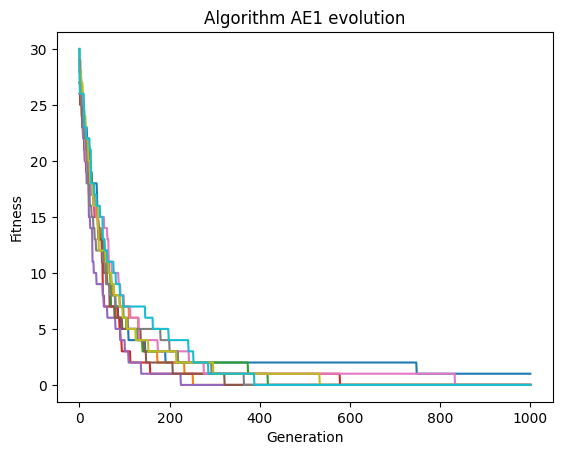

In [36]:
VisualizaEvolucion(best_outputs, "Algorithm AE1 evolution")

### Visualización de los tableros de las soluciones

In [37]:
# Mostrar los tableros de los mejores individuos de AE1
for i in range(n_repeat):
    print(f"Tablero AE1 - Run {i+1}:")
    mostrar_tablero(best_individuos[i])  # Mostrar tablero de AE1

Tablero AE1 - Run 1:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . .

### Nuevas ejecuciones del AE2 con $1000$ generaciones

In [38]:
# Ejecutar 10 runs, con mayor número de generaciones, con los mejores parámetros y reportar media, máximo, mínimo y desviación estándar

n_repeat = 10
G = 1000
N = 100
p_c = best_options_AE2['p_c']
p_m = best_options_AE2['p_m']
print("p_c:",p_c," p_m:",p_m)
best_outputs = np.full(n_repeat,None,dtype=object)
best_fitness = np.zeros(n_repeat)
best_individuos = []
for i in range(n_repeat):
    best_outputs[i], best_fitness[i], best_individuo = EA(G, N, p_c, p_m, f, n=64, random_state=i, selection_type='exponential')
    best_individuos.append(best_individuo)
print("Media: ",np.mean(best_fitness))
print("Máximo: ",np.max(best_fitness))
print("Mínimo: ",np.min(best_fitness))
print("Desviación estándar: ",np.std(best_fitness))

p_c: 0.67  p_m: 0.3


Generation: 1000 Fitness: 1.000000 : : 1001it [01:48,  9.18it/s]
Generation: 1000 Fitness: 1.000000 : : 1001it [01:39, 10.01it/s]
Generation: 202 Fitness: 0.000000 : : 203it [00:18, 10.69it/s]
Generation: 108 Fitness: 0.000000 : : 109it [00:10, 10.87it/s]
Generation: 114 Fitness: 0.000000 : : 115it [00:11, 10.10it/s]
Generation: 266 Fitness: 0.000000 : : 267it [00:25, 10.58it/s]
Generation: 88 Fitness: 0.000000 : : 89it [00:08, 11.11it/s] 
Generation: 1000 Fitness: 1.000000 : : 1001it [01:42,  9.79it/s]
Generation: 1000 Fitness: 1.000000 : : 1001it [01:41,  9.87it/s]
Generation: 1000 Fitness: 2.000000 : : 1001it [01:34, 10.61it/s]

Media:  0.6
Máximo:  2.0
Mínimo:  0.0
Desviación estándar:  0.66332495807108


Las 10 ejecuciones de AE2 con $1000$ generaciones han tardado 9 minutos y 42 segundos. Se logra alcanzar un fitness de $0$ y, por tanto, una solución válida, en 5 de los 10 runs.

### Visualización de la evolución del algoritmo AE2

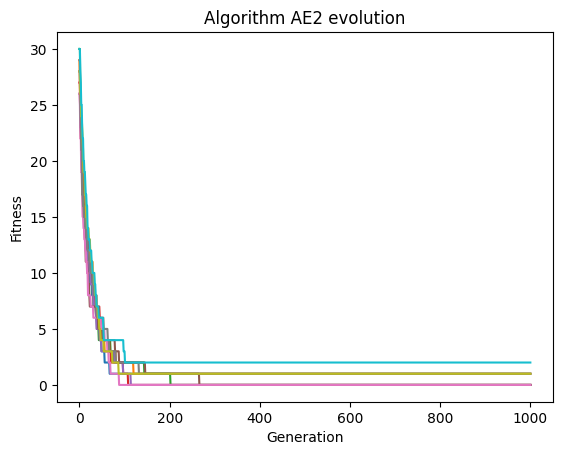

In [39]:
VisualizaEvolucion(best_outputs, "Algorithm AE2 evolution")

### Visualización de los tableros de las soluciones

In [40]:
# Mostrar los tableros de los mejores individuos de AE2
for i in range(n_repeat):
    print(f"Tablero AE2 - Run {i+1}:")
    mostrar_tablero(best_individuos[i])  # Mostrar tablero de AE2

Tablero AE2 - Run 1:
. . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . .
. . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . R .

### Conclusión

Con un número reducido de generaciones, AE2 funciona mejor ya que la selección por ranking exponencial favorece la exploración, evitando que el algoritmo quede atrapado en malas soluciones durante demasiado tiempo. Esto le permite disminuir el fitness de forma más efectiva en las primeras etapas.

Sin embargo, cuando se aumenta el número de generaciones, ocurre algo diferente: una vez que se encuentra un buen individuo, con un fitness muy cercano a $0$, AE1 aprovecha mejor esta situación. Gracias a la selección proporcional, los individuos con mejor fitness tienen una mayor probabilidad de selección, lo que acelera la propagación de la solución óptima dentro de la población. Así, la convergencia con AE1 es más rápida una vez que el óptimo es fácilmente alcanzable sin necesidad de demasiada exploración.

En contraste, AE2 sigue favoreciendo la exploración incluso cuando ya se ha encontrado una buena solución, con un fitness muy cercano a $0$. En lugar de centrarse en explotar ese individuo, sigue explorando otras soluciones y manteniendo una mayor variabilidad en la población, lo que puede retrasar la convergencia.

No obstante, en AE2 es posible ajustar el parámetro $c$ de la selección por ranking exponencial. Probablemente disminuyendo el valor de este parámetro se podría conseguir una convergencia más eficiente en las últimas generaciones, ya que un $c$ cercano a $0$ favorece un mayor número esperado de descendientes del mejor individuo. Esto mitigaría el problema de exploración excesiva, permitiendo que AE2 combinara una buena exploración inicial con una explotación más efectiva en las generaciones finales.